Autoencoders encode the input to identify important latent feature representation. It then decodes the latent features to reconstruct output values identical to the input values.

![](https://lilianweng.github.io/posts/2018-08-12-vae/autoencoder-architecture.png)

![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*E6o2V3B-Vep374feBNbyeA.png)

The encoder will compress the input data to its latent representation. The decoder will decompress the encoded latent representation to reconstruct the input data. The loss between the original input and the reconstructed input will be measured using the **SSIM (Structural Similarity Index Measure)** loss function. If the input belongs to images from the trained dataset then reconstruction loss will be smaller and if there is an anomaly then the reconstruction loss will be high.

SSIM is used to measure the similarity between two images. The SSIM value is between -1 and 1. SSIM value is larger if two images are similar.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load Fashion-MNIST Dataset

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data() # No need to import label data

# Scale Data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

### Create Encoder and Decoder

In [ ]:
IMG_SHAPE = (28, 28, 1)

### Leaky ReLU

![Leaky_Relu](https://raw.githubusercontent.com/shahkaran76/yolo_v3-tensorflow-ipynb/7472f58be09ba36094eb0b94a5406e83bb2e5386//images/prelu.jpg)

Suppose if, for whatever reason, the output of a ReLU is consistently 0 (for example, if the ReLU has a large negative bias), then the gradient through it will consistently be 0. The error signal backpropagated from later layers gets multiplied by this 0, so no error signal ever passes to earlier layers. In situations like that the Leaky ReLU is used.



In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 7.0 MB/s eta 0:00:00


### Build the Model

In [ ]:
import visualkeras

# Pass the gray scale input image of size(28,28,1)

inputs = tf.keras.Input(shape=IMG_SHAPE, name='input_layer')

# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)

# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)

# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)

# Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)

# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)

# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)

# output
outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)
autoencoder = tf.keras.Model(inputs, outputs)

### Viualise the Model

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 28, 28, 32)       128       
 tion)                                                           
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 14, 14, 64)       256       
 tion)                                                       

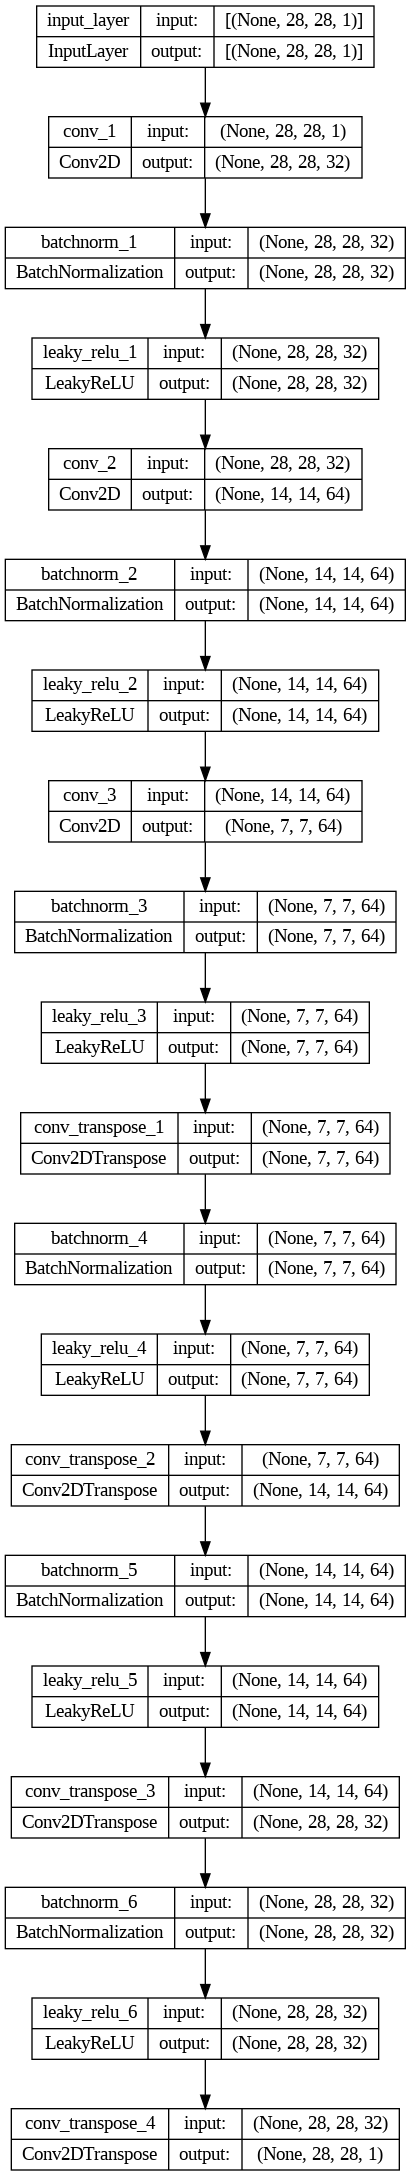

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

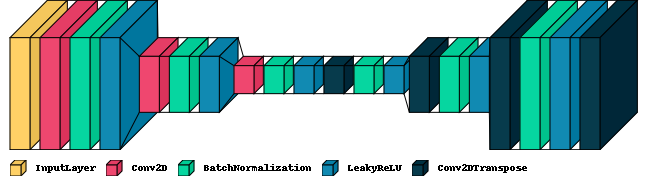

In [ ]:
from PIL import ImageFont

visualkeras.layered_view(autoencoder)
visualkeras.layered_view(autoencoder, legend=True,
                         # draw_volume=False,
                         # spacing=30
                         )

### SSIM Loss

SSIM measures Structural Similarity between two images in terms of luminance, contrast, and structure. A value of 1 for SSIM indicates identical images. You want the SSIM loss function to be a minimum when training the autoencoder on good images.

![](https://vicuesoft.com/glossary/ssim-ms-ssim.png)

The SSIM index is a development of traditional methods such as PSNR (peak signal-to-noise ratio) and the MSE method, which turned out to be incompatible with the physiology of human perception. The difference with other techniques such as MSE or PSNR is that these approaches estimate absolute errors. Structural information is the idea that the pixels have strong inter-dependencies especially when they are spatially close. These dependencies carry important information about the structure of the objects in the visual scene.

The SSIM index is calculated on various windows of an image. The above formula is applicable only for the brightness of the image, which is used to assess the quality. The resulting SSIM index ranges from -1 to +1. A value of +1 is achieved only with the complete authenticity of the samples. Typically, the metric is calculated for an 8 x 8 pixel window. The window can be displaced by a pixel, but experts recommend using groups of windows to reduce the complexity of the calculations.

A more advanced form of SSIM, called **Multiscale SSIM (MS-SSIM)**, is performed at multiple scales through a multi-step downsampling process, reminiscent of multiscale processing in the early visual system. It has been shown to perform equally well or better than SSIM with various databases of subjective images and videos.

In [ ]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

### Compile the Model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 128

In [ ]:
model_hist=autoencoder.fit(
                x_train, x_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(x_test, x_test)
                )

Epoch 1/10
469/469 [==============================] - 32s 20ms/step - loss: 0.0888 - val_loss: 0.2209
Epoch 2/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0258 - val_loss: 0.0219
Epoch 3/10
469/469 [==============================] - 9s 18ms/step - loss: 0.0184 - val_loss: 0.0225
Epoch 4/10
469/469 [==============================] - 10s 22ms/step - loss: 0.0150 - val_loss: 0.0158
Epoch 5/10
469/469 [==============================] - 10s 20ms/step - loss: 0.0130 - val_loss: 0.0110
Epoch 6/10
469/469 [==============================] - 9s 18ms/step - loss: 0.0114 - val_loss: 0.0120
Epoch 7/10
469/469 [==============================] - 8s 16ms/step - loss: 0.0103 - val_loss: 0.0092
Epoch 8/10
469/469 [==============================] - 9s 19ms/step - loss: 0.0096 - val_loss: 0.0087
Epoch 9/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/10
469/469 [==============================] - 7s 16ms/step - loss: 0.0084 - val

### Reconstruct the Fashion MNIST images for the test data and visualize

In [ ]:
VIS_SAMPLE_COUNT = 10

313/313 [==============================] - 1s 2ms/step


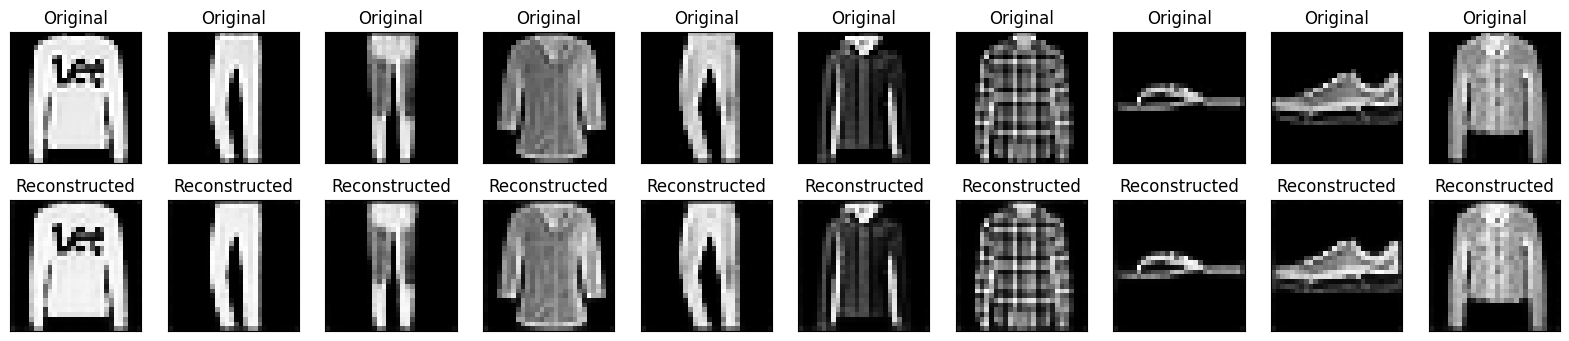

In [ ]:
decoded_imgs = autoencoder.predict(x_test)
plt.figure(figsize=(20, 4))

for i in range(1, VIS_SAMPLE_COUNT + 1):
    # Display original
    ax = plt.subplot(2, VIS_SAMPLE_COUNT, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, VIS_SAMPLE_COUNT, i + VIS_SAMPLE_COUNT)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Load MNIST Dataset

In [ ]:
(_, _), (x_mnisttest, _) = tf.keras.datasets.mnist.load_data()   # No need to import label data

# Scale Data
x_mnisttest = x_mnisttest.astype('float32') / 255.
x_mnisttest = np.reshape(x_mnisttest, (len(x_mnisttest), 28, 28, 1))

In [ ]:
VIS_SAMPLE_COUNT = 5

313/313 [==============================] - 1s 3ms/step


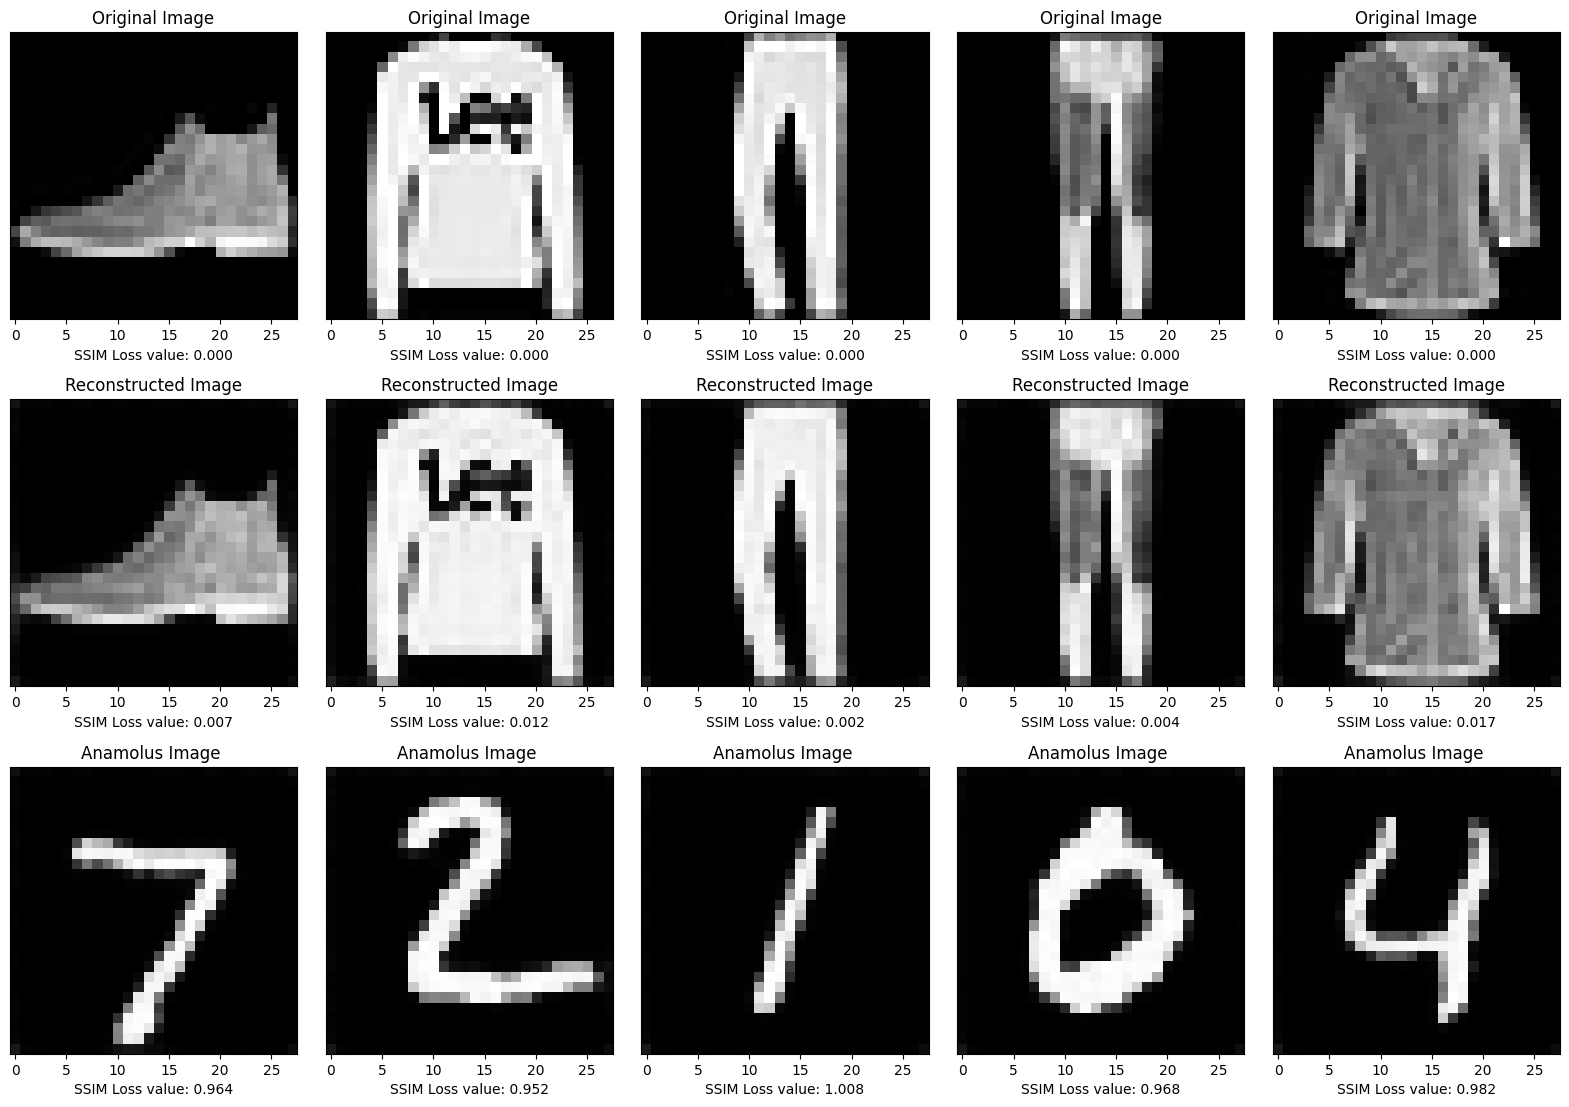

In [ ]:
decoded_imgs = autoencoder.predict(x_test)
decoded_mnistimgs= autoencoder.predict(x_mnisttest)

plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1

for i in range(VIS_SAMPLE_COUNT):
    # Original training dataset vs Original training
    ax = plt.subplot(3, VIS_SAMPLE_COUNT, plt_a)
    plt.imshow(x_test[i].reshape(28,28))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(x_test[i], x_test[i])  # Calculate SSIM
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, VIS_SAMPLE_COUNT, plt_a + VIS_SAMPLE_COUNT )
    plt.imshow(decoded_imgs[i].reshape(28,28))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(decoded_imgs[i], x_test[i])  # Calculate SSIM
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, VIS_SAMPLE_COUNT, plt_a + 2*VIS_SAMPLE_COUNT)
    plt.imshow(decoded_mnistimgs[i].reshape(28,28))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(decoded_mnistimgs[i], decoded_imgs[i])  # Calculate SSIM
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.show()

### Reference

https://medium.com/analytics-vidhya/image-anomaly-detection-using-autoencoders-ae937c7fd2d1

https://lilianweng.github.io/posts/2018-08-12-vae/